### Merge Stockfish self play dataset

Merges the different parts of the generated games uploaded by 
crazyhorse, ObiWanBenoni, Pichau,varvarakh and queensgambit

* author: QueensGambit
* parts of the code are based on a template written by `Matuiss2` on discord
* This code only works for single thread but given the dataset is realtively small it's should execute in < 3min

In [1]:
import chess.pgn
import glob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline
plt.style.use('seaborn-whitegrid')

### Settings

In [2]:
dataset_dir = "/media/queensgambit/5C483A84483A5CC8/Deep_Learning/data/stockfish/sf_vs_sf_selfplay/parts/"
export_full_dataset = True
export_plots = True

In [3]:
pgns = glob.glob(dataset_dir + '*.pgn')

In [4]:
if len(pgns) == 0:
    raise Exception('No pgns files are found in the directory %s' % dataset_dir)

In [5]:
def read_one_game(pgn):
    full_game = ""
        
    line = pgn.readline()
    # check if the word "Event" is found in the first line
    # if this is the case you call read_one_game(pgn) again
    event_found = "Event" in line

    full_game += line

    while line.strip() != '':
        line = pgn.readline()
        full_game += line
        
    if event_found is True:
        return full_game + read_one_game(pgn)
    else:
        return full_game

In [6]:
total = white = black = draw = 0

full_dataset_file = open
for pgn in pgns:
    pgn_file = open(pgn)
    
    for game in pgn_file:
        header = str(chess.pgn.read_headers(pgn_file))
        # make sure that the Termination wasn't "abandoned" or "unterminated"
        if 'Termination' not in header and "Result='?'" not in header: # everything was good
            total += 1
            if "Result='1-0'" in header:
                white += 1
            elif "Result='0-1'" in header:
                black += 1
            elif "Result='1/2-1/2'" in header:
                draw += 1
            else:
                raise Exception("Illegal header: %s" % header)

print(total, " games total")
print("White-Black-Draw: {}-{}-{}".format(white, black, draw))
print(
    "White-Black-Draw: {}% {}% {}%".format(
        round(white * 100 / total, 2), round(black * 100 / total, 2), round(draw * 100 / total, 2)
    )
)

121571  games total
White-Black-Draw: 80303-38796-2472
White-Black-Draw: 66.05% 31.91% 2.03%


In [7]:
if white+black+draw != total:
    raise Exception("Illegal state white+black+draw=%d and total=%d" % (white+black+draw, total))
else:
    print("All OK")    

All OK


### Create a plot

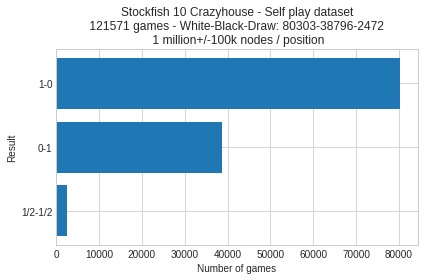

In [8]:
plt.barh(range(3), [draw,black, white])
ax = plt.gca()
ax.set_yticks(range(3))
ax.set_yticklabels(["1/2-1/2", "0-1", "1-0"])
plt.title('Stockfish 10 Crazyhouse - Self play dataset\n %d games - White-Black-Draw: %d-%d-%d \n \
1 million+/-100k nodes / position' % (total, white, black, draw))
plt.xlabel('Number of games')
plt.ylabel('Result')
plt.tight_layout()
if export_plots is True:
    plt.savefig('sf_self_play_dataset_stats.png')
    plt.savefig('sf_self_play_dataset_stats.pdf')    

### Define the train, test and validation sets

In [9]:
train_idcs, test_val_idcs = train_test_split(range(total), test_size=round(2000 / total, 5), random_state=42)

In [10]:
test_idcs, val_idcs = train_test_split(test_val_idcs, test_size=0.5, random_state=42)

In [11]:
print("%d training samples - %d validation samples - %d test samples" % (len(train_idcs), len(val_idcs), len(test_idcs))) 

119571 training samples - 1000 validation samples - 1000 test samples


In [12]:
if export_full_dataset is True:
    full_dataset = open("sf_vs_sf_cz_full_dataset.pgn", 'w')
    train_dataset = open("train/sf_vs_sf_cz_train.pgn", 'w')
    val_dataset = open("val/sf_vs_sf_cz_validation.pgn", 'w')    
    test_dataset = open("test/sf_vs_sf_cz_test.pgn", 'w')

### Export the dataset and the different splits

In [13]:
total = white = black = draw = 0

full_dataset_file = open

game_idx = 0

for pgn in pgns:
    pgn_file = open(pgn)
    game = None
    
    game = read_one_game(pgn_file)
    while game:
        # make sure that the Termination wasn't "abandoned" or "unterminated"
        if '1. ' in game and 'Termination' not in game: # everything was good
            total += 1
            if '[Result "1-0"]' in game:
                white += 1
            elif '[Result "0-1"]' in game:
                black += 1               
            elif '[Result "1/2-1/2"]' in game:
                draw += 1
            else:
                raise Exception("Illegal header: %s" % game)
            
            if export_full_dataset is True:
                full_dataset.write(game)
                
                if game_idx in val_idcs:
                    val_dataset.write(game)
                elif game_idx in test_idcs:
                    test_dataset.write(game)
                #elif game_idx in train_idcs:
                #    train_dataset.write(game)
                else:
                    train_dataset.write(game)
                #    raise Exception("The given index %d couldn't be assigned." % game_idx)
            # increase the game counter by 1
            game_idx += 1

        game = read_one_game(pgn_file)
    pgn_file.close()
print(total, " games total")
print("White-Black-Draw: {}-{}-{}".format(white, black, draw))
print(
    "White-Black-Draw: {}% {}% {}%".format(
        round(white * 100 / total, 2), round(black * 100 / total, 2), round(draw * 100 / total, 2)
    )
)

if export_full_dataset is True:
    train_dataset.close()
    val_dataset.close()
    test_dataset.close()

121571  games total
White-Black-Draw: 80303-38796-2472
White-Black-Draw: 66.05% 31.91% 2.03%


In [14]:
if white+black+draw != total:
    raise Exception("Illegal state white+black+draw=%d and total=%d" % (white+black+draw, total))
else:
    print("All OK")

All OK
